# Predict future sales - EDA and LSTM prediction

**This analysis includes an exploratory analysis of the data, an LSTM model, a plot of traing RMSE performance, and a look at the top 10 predictions of the model.**

Table of contents:
------------------
1. Read csv files
2. Add Russian to English translations
3. EDA - Explore data
4. Descriptive stats for item_cnt_day
5. Transform Dates
6. EDA - Time series trends
7. EDA - Explore data for items, categories, and shops
8. Drop outliers
9. Prepare the data for LSTM model
10. Model training plots
11. LSTM Model
12. Output predictions to csv
13. Top 10 predicted sales increases

## Read csv files

In [164]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  

In [165]:
### Colab only ###

# mount google drive from colab

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [166]:
### Colab only ###

# select your working directory

os.getcwd()
os.chdir('/content/drive/My Drive/Advanced Analytics/Advanced Analytics Project/')
os.getcwd()

'/content/drive/My Drive/Advanced Analytics/Advanced Analytics Project'

In [167]:
### Colab only ###

# Read the csv files from the unzipped file

sales = pd.read_csv("./competitive-data-science-predict-future-sales/sales_train.csv")
test = pd.read_csv("./competitive-data-science-predict-future-sales/test.csv")

shops = pd.read_csv("./competitive-data-science-predict-future-sales/shops.csv")
items = pd.read_csv("./competitive-data-science-predict-future-sales/items.csv")
item_categories = pd.read_csv("./competitive-data-science-predict-future-sales/item_categories.csv")

In [168]:
### Colab only ###

# Note that 3 of the above files have Russian text (shops, items, item_categories).
# We were having difficulty using the translate package because Google translate API limits the number of
# calls from any one url, and we had to make a call for each line in the csv (one of which has ~22k lines.)

# Luckily, Kaggle user 'deargle' kindly made the Russian to English translated columns available 
# He used Google Translate via python package mtranslate: https://pypi.org/project/mtranslate/

# Those csv files are accessible from the below urls:
# https://www.kaggle.com/c/competitive-data-science-predict-future-sales/discussion/54949#latest-580103

shops_t = pd.read_csv("./competitive-data-science-predict-future-sales/shops-translated.csv")
items_t = pd.read_csv("./competitive-data-science-predict-future-sales/items-translated.csv")
item_categories_t = pd.read_csv("./competitive-data-science-predict-future-sales/item_categories-translated.csv")

# However, they were not joined to the other columns in the original files yet so the following code does that.

In [169]:
### Colab only ###

items = items.merge(items_t, how='left', on='item_id')
del items['item_name']
items.rename(columns={'item_name_translated':'item_name'}, inplace=True)

In [170]:
### Colab only ###

item_categories = item_categories.merge(item_categories_t, how='left', on='item_category_id')
del item_categories['item_category_name']
item_categories.rename(columns={'item_category_name_translated':'item_category_name'}, inplace=True)

In [171]:
### Colab only ###

shops = shops.merge(shops_t, how='left', on='shop_id')
del shops['shop_name']
shops.rename(columns={'shop_name_translated':'shop_name'}, inplace=True)

In [172]:
### Kaggle only - comment this out in Colab ###


# Read the csv files

#sales = pd.read_csv("../input/competitive-data-science-predict-future-sales/sales_train.csv")
#test = pd.read_csv("../input/competitive-data-science-predict-future-sales/test.csv")
#items = pd.read_csv("../input/competitive-data-science-predict-future-sales/items.csv")



## Add Russian to English translations

(This step was not necessary, it is only to add some context to the background data. May be of some use for feature selection in the future.)

In [173]:
### Kaggle only - comment this out in Colab ###

# Three of the files in the dataset have Russian text (shops, items, item_categories).
# Kaggle user 'Orhan' kindly made the Russian to English translated files available as a dataset
# https://www.kaggle.com/orhankaramancode/filestranslated

#shops_t = pd.read_csv("../input/filestranslated/shops-translated.csv")
#items_t = pd.read_csv("../input/filestranslated/items-translated.csv")
#item_categories_t = pd.read_csv("../input/filestranslated/categories_translated.csv")

In [174]:
### Kaggle only - comment this out in Colab ###

# items (items-translated.csv was missing the category ids - join to the original items.csv)
#del items['item_name']
#items = items.merge(items_t, how='left', on='item_id')
#items.rename(columns={'item_name_translated':'item_name'}, inplace=True)

In [175]:
### Kaggle only - comment this out in Colab ###

# item categories
#del item_categories_t['Unnamed: 0']
#item_categories = item_categories_t

In [176]:
### Kaggle only - comment this out in Colab ###

#shops
#shops_t.rename(columns={'shop_name_translated':'shop_name'}, inplace=True)
#shops = shops_t

## EDA - Explore data

Preliminary EDA with descriptive statistics

In [177]:
# Sales:

print('rows and columns:', sales.shape, '\n')
print(sales.info(), '\n')
print(sales.count(), '\n')
print('missing values:\n', sales.isna().sum())

rows and columns: (2935849, 6) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB
None 

date              2935849
date_block_num    2935849
shop_id           2935849
item_id           2935849
item_price        2935849
item_cnt_day      2935849
dtype: int64 

missing values:
 date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64


In [178]:
sales.sort_values(by=['date','shop_id','item_id']).head(5)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
32569,01.01.2013,0,2,991,99.0,1.0
32552,01.01.2013,0,2,1472,2599.0,1.0
32632,01.01.2013,0,2,1905,249.0,1.0
32459,01.01.2013,0,2,2920,599.0,2.0
32504,01.01.2013,0,2,3320,1999.0,1.0


### Descriptive stats for item_cnt_day

Since the task is to predict counts for each item-store combination in one month, it will be good to look at the statistics for the item_cnt_day column.

* max count is much higher than the average, indicating large outliers 
* the min count is -22, indicating item returns 
* the 25% and 75% quartiles for item_cnt_day = 1.0, indicating most sales are for one item

In [179]:
print('\nitem_cnt_day descriptive statistics')
print( sales.item_cnt_day.describe().apply(lambda x: format(x, '10.1f')) )


item_cnt_day descriptive statistics
count     2935849.0
mean            1.2
std             2.6
min           -22.0
25%             1.0
50%             1.0
75%             1.0
max          2169.0
Name: item_cnt_day, dtype: object


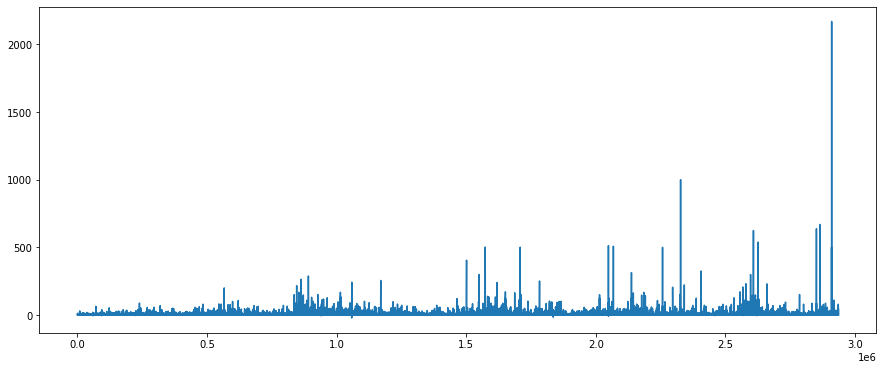

In [180]:
# The item_count series shows some purchases with huge counts

sales.item_cnt_day.plot(figsize=(15, 6))
plt.show()

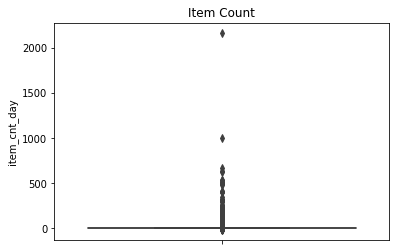

In [181]:
# there are lots of outliers in the with large quantities


sns.boxplot(y="item_cnt_day", data=sales)
plt.title('Item Count')
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


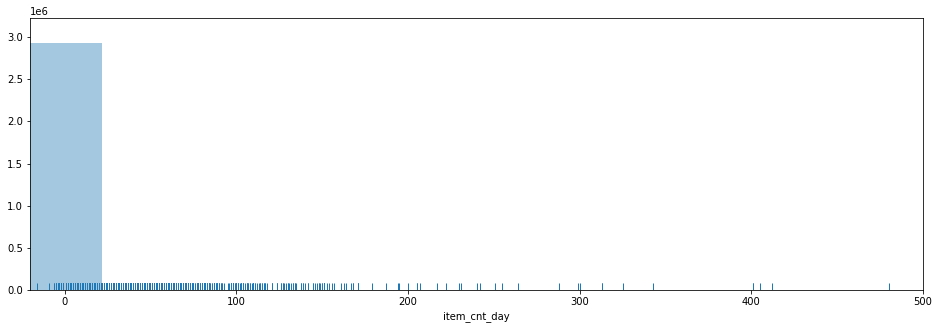

In [182]:
# Generate item_cnt_day outliers plot

plt.figure(figsize=(16,5))
sns.distplot(sales['item_cnt_day'], kde=False, rug=True)
plt.xlim(-20, 500)
plt.show()

In [183]:
# how many zero or negative item_cnt_days?

print( 'zero item_cnt_days:', len ( sales.loc[sales['item_cnt_day']==0] ) )
print( 'negative item_cnt_days:', len ( sales.loc[sales['item_cnt_day']<0] ) )

zero item_cnt_days: 0
negative item_cnt_days: 7356


## Transform Dates
* convert date field to datetime
* add some additional date features 

In [184]:
# convert the date field to pandas datetime

sales.loc[ : , ('date') ] = pd.to_datetime(sales.loc[ : , ('date') ],format='%d.%m.%Y')

In [185]:
# add year, month, and day columns

sales['year'] = sales['date'].dt.year
sales['month'] = sales['date'].dt.month
sales['day'] = sales['date'].dt.day

In [186]:
# create a year-month field

sales['year_month'] = sales['date'].map(lambda x: 100*x.year + x.month)

In [187]:
# create a weekday field (0=Mon, 6=Sun)

sales['day_of_week'] = sales['date'].map(lambda x: x.weekday())

In [188]:
# Sort values in dataframe, order the columns, reset the index

sales = sales.sort_values(by=['date','shop_id','item_id'], ascending=[True,True,True])

sales_dates = ['date','date_block_num','year_month','year','month','day','day_of_week']
sales_data = ['shop_id','item_id','item_price','item_cnt_day']
sales = sales[sales_dates + sales_data]

sales.reset_index(drop=True,inplace=True)

In [189]:
sales.head()

,date,date_block_num,year_month,year,month,day,day_of_week,shop_id,item_id,item_price,item_cnt_day
0,2013-01-01,0,201301,2013,1,1,1,2,991,99.0,1.0
1,2013-01-01,0,201301,2013,1,1,1,2,1472,2599.0,1.0
2,2013-01-01,0,201301,2013,1,1,1,2,1905,249.0,1.0
3,2013-01-01,0,201301,2013,1,1,1,2,2920,599.0,2.0
4,2013-01-01,0,201301,2013,1,1,1,2,3320,1999.0,1.0


## EDA - Time series trends

In [190]:
daily_count_sum = sales.groupby('date')['item_cnt_day'].sum()

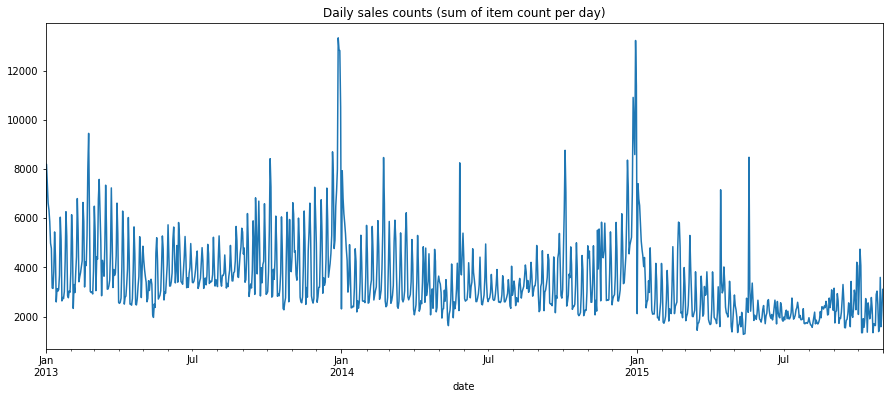

In [191]:
# Overall time series trend - downward sales volume 

daily_count_sum.plot(figsize=(15, 6))
plt.title('Daily sales counts (sum of item count per day)')
plt.show()

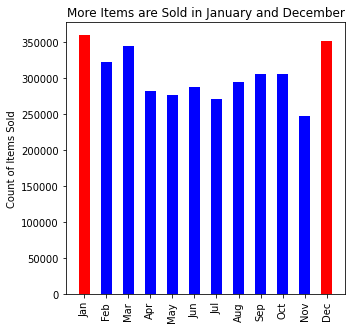

In [192]:
# Yearly trend shows certain months like January and December have higher volumes

# Monthly sums

count_by_month = pd.DataFrame(sales.groupby('month')['item_cnt_day'].sum() )
count_by_month.reset_index(inplace=True)


# (January is 1)

count_by_month_jd = count_by_month.loc[ count_by_month['month'].isin([1,12]) ]
count_by_month_other = count_by_month.loc[ ~ count_by_month['month'].isin([1,12]) ]



# Graph the data

objects = ('Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec')
objects_other = ('Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov')
objects_jd = ('Jan', 'Dec')

x_pos = np.arange(len(objects))
x_pos_other = np.array([1,2,3,4,5,6,7,8,9,10])
x_pos_jd = np.array([0,11])

plt.figure(figsize=(5,5))
width=0.5

rects_other = plt.bar(x_pos_other, count_by_month_other.item_cnt_day, width, color='b')
rects_jd = plt.bar(x_pos_jd, count_by_month_jd.item_cnt_day, width, color='r')

plt.xticks(x_pos, objects, rotation=90)
plt.title('More Items are Sold in January and December')
plt.ylabel('Count of Items Sold')
plt.xlabel(None)
plt.show() 

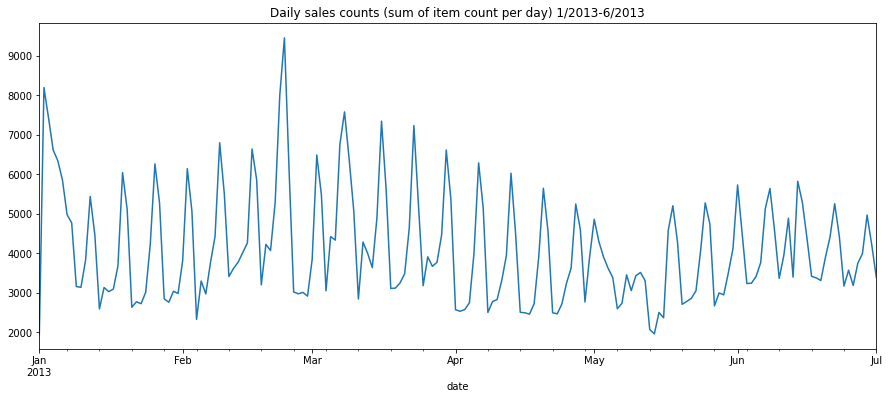

In [193]:
# Weekly time series trend - peaks and troughs can be observed for every week

daily_count_sum['2013-01-01':'2013-07-01'].plot(figsize=(15, 6)) # weekly peaks/troughs can be observed
plt.title('Daily sales counts (sum of item count per day) 1/2013-6/2013')
plt.show()

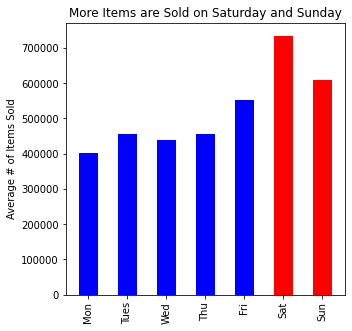

In [194]:
# Weekly cycles occur because weekend sales are higher

count_by_day = pd.DataFrame( sales.groupby('day_of_week')['item_cnt_day'].sum() )
count_by_day.reset_index(inplace=True)

# weekdays, weekends

count_by_day_we = count_by_day.loc[ count_by_day['day_of_week']>=5 ]
count_by_day_wd = count_by_day.loc[ count_by_day['day_of_week']< 5 ]

# Graph

objects = ('Mon','Tues','Wed','Thu','Fri','Sat','Sun')
objects_wd = ('Mon','Tues','Wed','Thu','Fri')
objects_we = ('Sat','Sun')

x_pos = np.arange(len(objects))
x_pos_wd = np.arange(len(objects_wd))
x_pos_we =(5,6)

plt.figure(figsize=(5,5))
width=0.5

rects_wd = plt.bar(x_pos_wd, count_by_day_wd.item_cnt_day, width, color='b')
rects_we = plt.bar(x_pos_we, count_by_day_we.item_cnt_day, width, color='r')

plt.xticks(x_pos, objects, rotation=90)
plt.title('More Items are Sold on Saturday and Sunday')
plt.ylabel('Average # of Items Sold')
plt.xlabel(None)
plt.show() 

## EDA - Explore data for items, categories, and shops

In [195]:
# merge sales data with descriptive data for items, shops and categories

sales = pd.merge(sales,items,how='left',on='item_id', copy=False)
sales = sales.merge(item_categories,how='left',on='item_category_id', copy=False)
sales = sales.merge(shops,how='left',on='shop_id', copy=False)

In [196]:
sales.head()

,date,date_block_num,year_month,year,month,day,day_of_week,shop_id,item_id,item_price,item_cnt_day,item_category_id,item_name,item_category_name,shop_name
0,2013-01-01,0,201301,2013,1,1,1,2,991,99.0,1.0,67,"3D Action Puzzle ""Dinosaurs"" Tyrannosaurus",Gifts - Development,"Adygea Shopping Center ""Mega"""
1,2013-01-01,0,201301,2013,1,1,1,2,1472,2599.0,1.0,23,"Assassin's Creed 3 [Xbox 360, Russian version]",Games - XBOX 360,"Adygea Shopping Center ""Mega"""
2,2013-01-01,0,201301,2013,1,1,1,2,1905,249.0,1.0,30,"Bestseller. Grand Theft Auto: San Andreas [PC,...",PC Games - Standard Edition,"Adygea Shopping Center ""Mega"""
3,2013-01-01,0,201301,2013,1,1,1,2,2920,599.0,2.0,21,Disney. LEGO Pirates of the Caribbean (Essenti...,Games - PSP,"Adygea Shopping Center ""Mega"""
4,2013-01-01,0,201301,2013,1,1,1,2,3320,1999.0,1.0,19,"FIFA 13 (with PS Move support) [PS3, Russian v...",Games - PS3,"Adygea Shopping Center ""Mega"""


In [197]:
#The item which sold the most units:
sales.loc[sales['item_cnt_day']==sales['item_cnt_day'].max()]

,date,date_block_num,year_month,year,month,day,day_of_week,shop_id,item_id,item_price,item_cnt_day,item_category_id,item_name,item_category_name,shop_name
2928870,2015-10-28,33,201510,2015,10,28,2,12,11373,0.908714,2169.0,9,Delivery to the point of issue (Boxberry),Delivery of goods,Online shop Emergency


In [198]:
item_category_count_sums = pd.DataFrame( sales.groupby(['item_category_name'])['item_cnt_day'].sum() )
item_category_count_sums = item_category_count_sums.reset_index() 

In [199]:
iccs_sort = item_category_count_sums.sort_values(by='item_cnt_day', ascending=False)
iccs_sort.reset_index(inplace=True, drop=True)

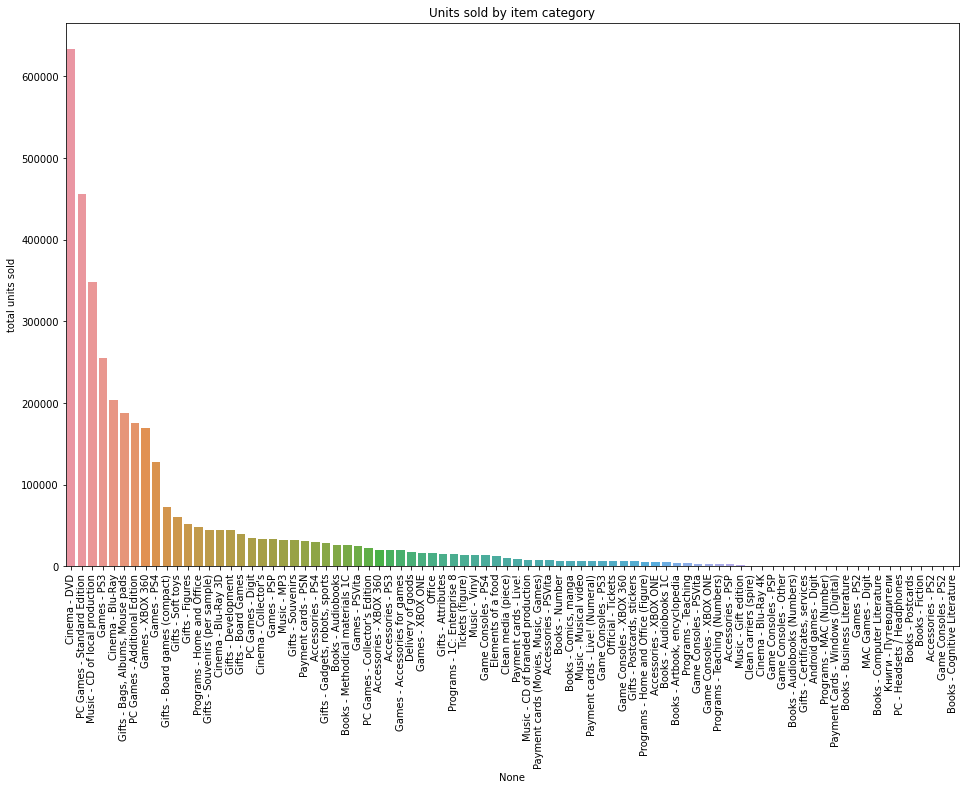

In [200]:
plt.figure(figsize=(16,10))
sns.barplot(x='item_category_name', y='item_cnt_day', data=item_category_count_sums, order=iccs_sort.item_category_name )
plt.xticks(rotation=90)
plt.xlabel('None')
plt.ylabel('total units sold')
plt.title('Units sold by item category')
plt.show()

In [201]:
shop_count_sums = pd.DataFrame( sales.groupby(['shop_name'])['item_cnt_day'].sum() )
shop_count_sums = shop_count_sums.reset_index() 

In [202]:
scs_sort = shop_count_sums.sort_values(by='item_cnt_day', ascending=False)
scs_sort.reset_index(inplace=True,drop=True)

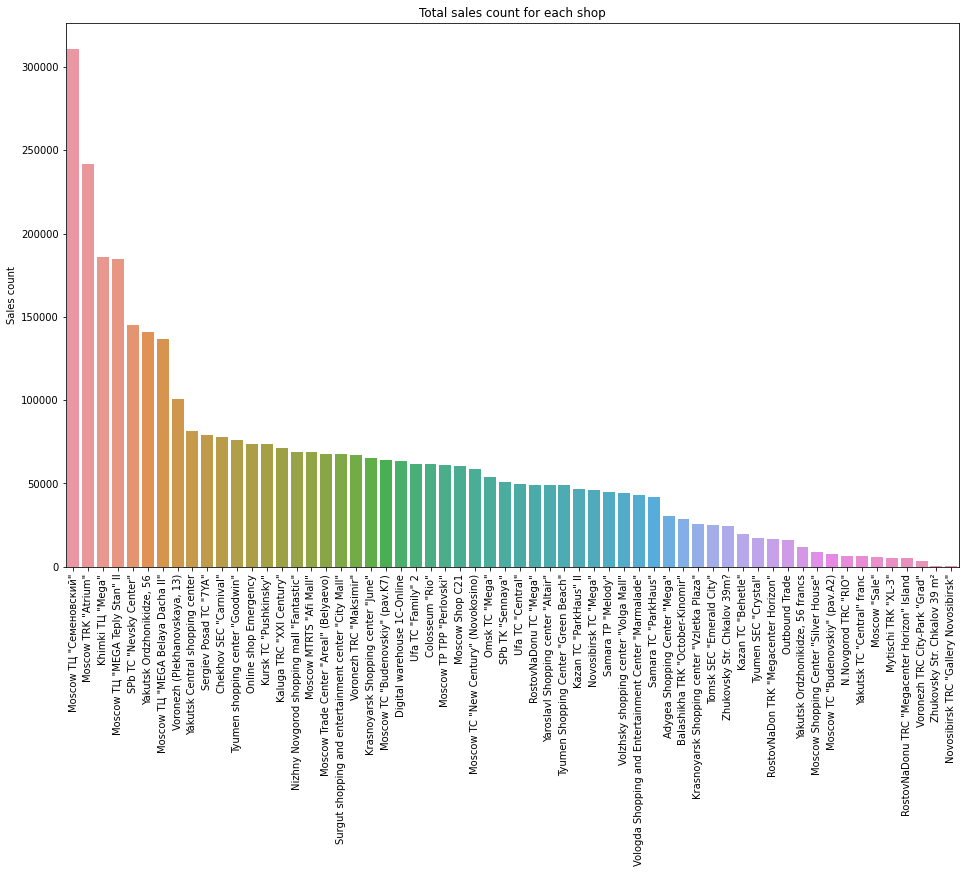

In [203]:
plt.figure(figsize=(16,10))
sns.barplot(x='shop_name', y='item_cnt_day', data=shop_count_sums, order=scs_sort.shop_name)
plt.xticks(rotation=90)
plt.xlabel(None)
plt.ylabel('Sales count')
plt.title('Total sales count for each shop')
plt.show()

## Drop outliers 

In [204]:
# drop any records with item_cnt_day above x, where x can be changed before fitting the model.

print(sales.shape)
sales = sales.loc[ sales['item_cnt_day'] <= 25 ]
print(sales.shape)

(2935849, 15)
(2933549, 15)


## Prepare the data for LSTM model

In [205]:
# Pivot the table to wide format
# rows = shop_id+item_id
# columns = date_block_num as the columns 
# values = sum(item_cnt_day)
# 

sales_monthly = sales.pivot_table(index = ['shop_id','item_id']
                                  ,values = ['item_cnt_day']
                                  ,columns = ['date_block_num']
                                  ,fill_value = 0
                                  ,aggfunc='sum')

In [206]:
sales_monthly.reset_index(inplace = True)
sales_monthly.head()

shop_id item_id item_cnt_day               ...                     
date_block_num                            0   1  2  3  4  ... 27 28 29 30 31 32 33
0                    0      30            0  31  0  0  0  ...  0  0  0  0  0  0  0
1                    0      31            0  11  0  0  0  ...  0  0  0  0  0  0  0
2                    0      32            6  10  0  0  0  ...  0  0  0  0  0  0  0
3                    0      33            3   3  0  0  0  ...  0  0  0  0  0  0  0
4                    0      35            1  14  0  0  0  ...  0  0  0  0  0  0  0

[5 rows x 36 columns]

In [207]:
# Left join merge the test data with the training data on item_id and shop_id
# This keeps all shop+item combinations that are required by the test set 
# and drops those from the training set that are not.

sales_monthly = pd.merge(test,sales_monthly,on = ['shop_id', 'item_id'],how = 'left')

/usr/local/lib/python3.6/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:3887: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [208]:
#filling NaN with zeroes
sales_monthly.fillna(0,inplace = True)

In [209]:
# Drop Id, shop_id, and item_id as they are uniquely captured by the index

sales_monthly.drop(['ID', 'shop_id','item_id','ID'],inplace = True, axis = 1)
sales_monthly.head()

,"(item_cnt_day, 0)","(item_cnt_day, 1)","(item_cnt_day, 2)","(item_cnt_day, 3)","(item_cnt_day, 4)","(item_cnt_day, 5)","(item_cnt_day, 6)","(item_cnt_day, 7)","(item_cnt_day, 8)","(item_cnt_day, 9)","(item_cnt_day, 10)","(item_cnt_day, 11)","(item_cnt_day, 12)","(item_cnt_day, 13)","(item_cnt_day, 14)","(item_cnt_day, 15)","(item_cnt_day, 16)","(item_cnt_day, 17)","(item_cnt_day, 18)","(item_cnt_day, 19)","(item_cnt_day, 20)","(item_cnt_day, 21)","(item_cnt_day, 22)","(item_cnt_day, 23)","(item_cnt_day, 24)","(item_cnt_day, 25)","(item_cnt_day, 26)","(item_cnt_day, 27)","(item_cnt_day, 28)","(item_cnt_day, 29)","(item_cnt_day, 30)","(item_cnt_day, 31)","(item_cnt_day, 32)","(item_cnt_day, 33)"
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [210]:
sales_monthly.shape

(214200, 34)

In [211]:
# select all the columns except for the last one for the training set
# expand to an array of 3 dimensions with shape (214200, 33, 1)

X_train = np.expand_dims(sales_monthly.values[:,:-1],axis=2)
X_train.shape

(214200, 33, 1)

In [212]:
# The last column is our training labels (or truth values)
# creates a 2d array with shape (214200, 1) 

y_train = sales_monthly.values[:,-1:]
y_train.shape

(214200, 1)

In [213]:
# select all the columns except for the first one for the 'test' set 
# expand to an array of 3 dimensions with shape (214200, 33, 1)

# note that it must include the last column, unlike the training set,
# but doesn't include the first columns so the arrays can be the same shape.

X_test = np.expand_dims(sales_monthly.values[:,1:],axis=2)
X_test.shape

(214200, 33, 1)

## Model training plots 

In [214]:
import math
import matplotlib.pyplot as plt

In [215]:
def rmse(acc):
  rmse =[]
  for i in acc:
    rmse.append(math.sqrt(i))
  return rmse

In [216]:
def plot_train_curve(history):

    colors = ['#e66101','#fdb863']
    accuracy = rmse(history.history['mean_squared_error'])
    epochs = range(len(accuracy))
    with plt.style.context("ggplot"):
        plt.figure(figsize=(8, 8/1.618))
        plt.ticklabel_format(useOffset=False)
        plt.plot(epochs, accuracy, marker='o', c=colors[0], label='Training RMSE')
        
        axes = plt.gca()

        plt.title('Training RMSE')
        plt.legend()
        plt.show()

## LSTM Model

In [217]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.models import load_model, Model

lstm_model_1 = Sequential()
lstm_model_1.add(LSTM(units = 64 , input_shape = (33,1), activation='relu'))
lstm_model_1.add(Dropout(0.5))
lstm_model_1.add(Dense(1))

lstm_model_1.compile(loss='mse',optimizer = 'adam',metrics=['mean_squared_error'])
lstm_model_1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 64)                16896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


In [218]:
lstm_model_1_history = lstm_model_1.fit(X_train,y_train,batch_size=4096,epochs=20)

Epoch 1/20
53/53 [==============================] - 3s 52ms/step - loss: 7.1143 - mean_squared_error: 7.1143
Epoch 2/20
53/53 [==============================] - 3s 55ms/step - loss: 4.6803 - mean_squared_error: 4.6803
Epoch 3/20
53/53 [==============================] - 3s 50ms/step - loss: 19.2106 - mean_squared_error: 19.2106
Epoch 4/20
53/53 [==============================] - 3s 57ms/step - loss: 5.0960 - mean_squared_error: 5.0960
Epoch 5/20
53/53 [==============================] - 3s 59ms/step - loss: 5.9107 - mean_squared_error: 5.9107
Epoch 6/20
53/53 [==============================] - 3s 57ms/step - loss: 3.6142 - mean_squared_error: 3.6142
Epoch 7/20
53/53 [==============================] - 3s 55ms/step - loss: 3.1630 - mean_squared_error: 3.1630
Epoch 8/20
53/53 [==============================] - 3s 53ms/step - loss: 4.1492 - mean_squared_error: 4.1492
Epoch 9/20
53/53 [==============================] - 3s 54ms/step - loss: 2.6821 - mean_squared_error: 2.6821
Epoch 10/20
53/53

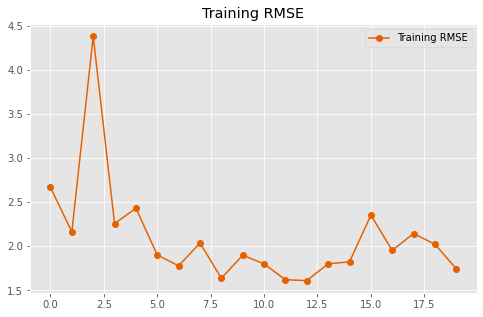

In [219]:
plot_train_curve(lstm_model_1_history)

## Output predictions to csv

In [220]:
output = lstm_model_1.predict(X_test)
submission = pd.DataFrame({'ID':test['ID'],'item_cnt_month':output.ravel()})
submission.head()

,ID,item_cnt_month
0,0,0.540834
1,1,0.162737
2,2,0.603939
3,3,0.211151
4,4,0.162737


In [221]:
submission.to_csv('sample_submission_lstm_model_1.csv',index = False)

## Top 10 predicted sales increases

In [222]:
# Get sales for the last month and the predicted sales for the next month

lstm_predictions = list(output)
last_month = list(y_train)
predicted_changes = pd.DataFrame( {'last':last_month, 'pred':lstm_predictions})

In [223]:
# Get the percent difference for (predicted sales next month - sales previous month)

predicted_changes['pct_diff'] = (predicted_changes['pred'] - predicted_changes['last'])/predicted_changes['last']

In [224]:
# Remove any non-numeric results, sort the store-items by percent change, and get the top 10

predicted_changes = predicted_changes[ ~ predicted_changes['pct_diff'].isin([np.nan, np.inf, -np.inf]) ]
predicted_changes.sort_values(by='pct_diff', ascending=False, inplace=True)
predicted_changes = predicted_changes[0:9] 

In [225]:
# Reset the index and name the column ID

predicted_changes.reset_index(inplace=True)
predicted_changes.rename(columns={'index': 'ID'}, inplace=True)

In [226]:
# Join the top 10 changes with the descriptions for shop, item, and item category

predicted_changes = pd.merge(predicted_changes, test, on = ['ID'], how = 'left')
predicted_changes = pd.merge(predicted_changes, shops, on = ['shop_id'], how = 'left')
predicted_changes = pd.merge(predicted_changes, items, on = ['item_id'], how = 'left')
predicted_changes = pd.merge(predicted_changes, item_categories, on = ['item_category_id'], how = 'left')

In [227]:
# Only keep the descriptive columns and format the percentages

predicted_changes = predicted_changes[['item_name','item_category_name','shop_name','pct_diff']]

def format_pcts(x):
  x = x.astype(float)
  x = x * 100
  x = round(x,2)
  return x
  
predicted_changes['pct_diff'] = format_pcts(predicted_changes['pct_diff'])
predicted_changes.head(10)

,item_name,item_category_name,shop_name,pct_diff
0,Corporate package T-shirt 1C Interest white (3...,"Gifts - Bags, Albums, Mouse pads",Zhukovsky Str. Chkalov 39m?,1148.34
1,"Grand Theft Auto V [PS3, Russian subtitles]",Games - PS3,"Krasnoyarsk Shopping center ""June""",1010.46
2,"Some of us [PS3, Russian version]",Games - PS3,"Moscow ТЦ ""Семеновский""",979.46
3,"StarCraft II: Wings of Liberty [PC, Jewel, Rus...",PC Games - Standard Edition,"Moscow ТЦ ""Семеновский""",636.61
4,"Grand Theft Auto V [Xbox 360, Russian subtitles]",Games - XBOX 360,"Ufa TC ""Family"" 2",477.86
5,"InFAMOUS: The second son [PS4, Russian version]",Games - PS4,"Moscow ТЦ ""Семеновский""",425.20
6,"Some of us [PS3, Russian version]",Games - PS3,"Moscow ТЦ ""MEGA Teply Stan"" II",423.35
7,Gambling addiction. Editor's Choice. Call of D...,PC Games - Standard Edition,Yakutsk Central shopping center,401.64
8,"Diablo III [PC, Jewel, Russian version]",PC Games - Standard Edition,"Moscow TRK ""Atrium""",388.99
